In [276]:
import numpy as np
from skimage import io
import cv2 as cv
from scipy.ndimage import interpolation as inter
import matplotlib.pyplot as plt
import commonfunctions as cf
# DataSetPATH = "../input/fonts-dataset-cmp/fonts-dataset" # for kaggle
DataSetPATH = "./Dataset" # for local

In [277]:
def showImage(image,title):
    plt.imshow(image,cmap='gray')
    plt.title(title)
    plt.show()

In [278]:
def ThresholdImage(image,Trac=False):
    img=image.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # use THRESH_OTSU to detect the threshold value automatically
    img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    num_ones = np.count_nonzero(img)
    num_zeros = img.size - num_ones

    # it means that background is white and text is black
    if num_ones > num_zeros:
        img = cv.bitwise_not(img)
    if Trac:
        print(num_ones, num_zeros)
        cf.show_images([img], ["Thresholded Image White background and Black text"])
    return img

In [279]:
def RemoveSaltPepperNoise(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = cv.medianBlur(img, 3)
    if Trace:
        cf.show_images([img], ["Image after removing Salt and Pepper Noise"])
    return img

In [309]:
def DeskewImage(image,Trace=False):
    original = image.copy()
    img = image.copy()
    thresh = cv.GaussianBlur(img, (9, 9), 0)
    # Resize the image with a fixed height.
    resized_height = 480
    percent = resized_height / len(img)
    resized_width = int(percent * len(img[0]))
    thresh = cv.resize(thresh, (resized_width, resized_height))

    # Draw a rectangle around the border to remove border lines.
    start_point = (0, 0) 
    end_point = (thresh.shape[0], thresh.shape[1])
    color = (255, 255, 255) 
    thickness = 10
    thresh = cv.rectangle(thresh, start_point, end_point, color, thickness)
    if Trace:
        io.imshow(thresh)
        io.show()

    # Dilate the text to make the text lines more obvious.
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (30, 5))
    dilate = cv.dilate(thresh, kernel)
    if Trace:
        io.imshow(dilate)
        io.show()
    # Find all the contours based on the dilated image.
    contours, hierarchy = cv.findContours(
        dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )

    # show the contours
    if Trace:
        img = cv.drawContours(original, contours, -1, (0, 255, 0), 5)
        cf.show_images([img], ["Contours"])

    # Use minAreaRect to get the rotation angles of contours.
    angles = []
    for contour in contours:
        minAreaRect = cv.minAreaRect(contour)
        angle = minAreaRect[-1]
        if angle != 90.0 and angle != -0.0: #filter out 0 and 90
            angles.append(angle)

    angles.sort()
    # Use the median as the skewed angle.
    print(int(len(angles) / 2))
    mid_angle = angles[int(len(angles)/2)] if len(angles)!=0 else 0
    if Trace:
        print(angles)
        print(angle)
        print(mid_angle)
    # # Rotate the image to deskew the text.
    # if angle > 45:  # anti-clockwise
    #     angle = -(90 - angle)
    height = original.shape[0]
    width = original.shape[1]
    m = cv.getRotationMatrix2D((width / 2, height / 2), mid_angle, 1)
    deskewed = cv.warpAffine(original, m, (width, height), borderValue=(0,0,0))

    return deskewed

In [281]:
def Preprocessing(image,trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = RemoveSaltPepperNoise(img, trace)
    # Threshold the image
    img = ThresholdImage(img, trace)
    # Deskew the image
    deskewed = DeskewImage(img, trace)
    return deskewed

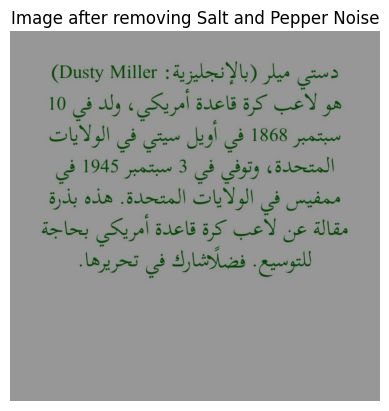

1337892 56869


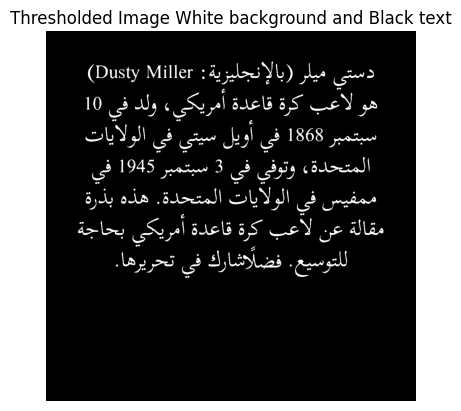

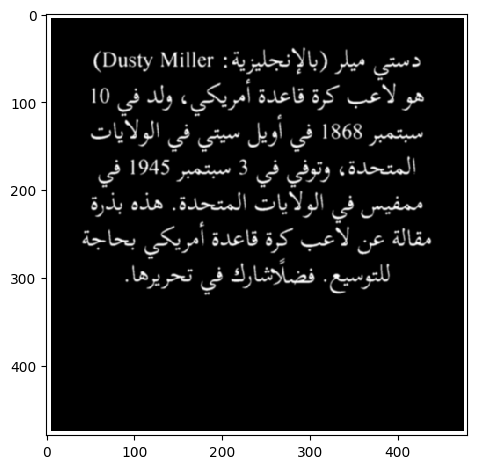

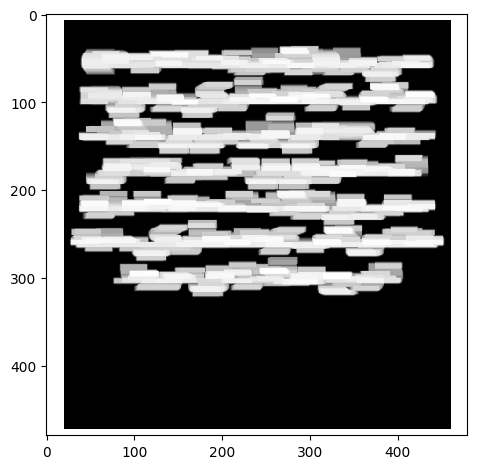

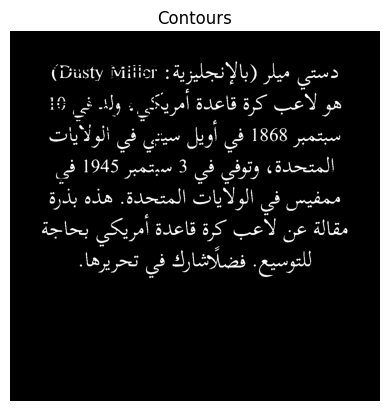

1
[71.56504821777344, 84.5596694946289, 89.3117904663086]
90.0
84.5596694946289


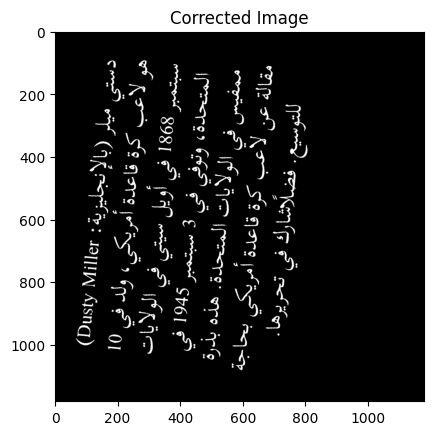

In [308]:
img = io.imread(f"{DataSetPATH}/Scheherazade New/548.jpeg")
# cf.showHist(img)
# io.imshow(img)

# corrected = RemoveSaltPepperNoise(img, True)
corrected = Preprocessing(img, True)

showImage(corrected,"Corrected Image")
io.imsave("corrected.jpg", corrected)
# io.imshow(corrected)